In [98]:
import os
import fastparquet
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from multiprocessing import Pool
from glob import glob

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [99]:
def fast_scatter(df,frac,elev,azim):
    """
    Faster scatter plot due to sampling.

    Parameters
    ----------
    df : dataFrame
        dataFrame with four cols 'X','Y','Z','labels'

    Returns
    -------
    None --> generates scatter plot       
    """

    # get data sample
    df = df.sample(frac=frac)

    # Create 3D plot
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(projection='3d')
    ax.scatter(df.X, df.Y, df.Z, c=df.labels)

    # Customize plot
    # ax.axis('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [100]:
def apply_KMeans(A,m=10,num_clusters=3):
    """
    Apply KMeans to input data.
    Get cluster labels sorted in z-Dir.

    Parameters
    ----------
    A : ndarray
        array of shape n x 3 with cols: 'X','Y','Z'
    m : float
        scaling factor for z-Dir 

    Returns
    -------
    sorted labels: ndarray
        labels for clusters sorted by cluster size
    """

    # normalize data
    scaler = StandardScaler().fit(A)
    A = scaler.transform(A)

    # scale data in z-Dir for better separation
    A[:,2] = A[:,2] * m

    # apply the clustering algorithm
    kmeans = KMeans(n_clusters=num_clusters,n_init=10).fit(A)
    labels = kmeans.labels_

    # sort clusters in z-Dir
    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(num_clusters)
    sorted_labels = lut[labels]

    return sorted_labels

In [1]:
def apply_DBSCAN(A,eps,m):
    """
    Apply DBSCAN to input data.
    Get cluster labels sorted by cluster size.

    Parameters
    ----------
    A : ndarray
        array of shape n x 3 with cols: 'X','Y','Z'
    eps: float
        epsilon distance --> look in sklearn DBSCAN documentation
    m : float
        scaling factor for z-Dir 

    Returns
    -------
    sorted labels: ndarray
        labels for clusters sorted by cluster size
    """

    # normalize data
    scaler = StandardScaler().fit(A)
    A = scaler.transform(A)

    # scale data in z-Dir for better separation
    A[:,2] = A[:,2] * m

    # run the DBSCAN clustering algorithm and get labels
    dbscan = DBSCAN(eps=eps, min_samples=10,n_jobs=-1)
    dbscan.fit(A)
    labels = dbscan.labels_

    # Compute the highest point for each cluster
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    highest_points = np.zeros((num_clusters, 3))
    for i in range(num_clusters):
        cluster_points = A[labels == i]
        highest_point = cluster_points[np.argmax(cluster_points[:, 2])]
        highest_points[i] = highest_point

    # Sort the clusters by the z-coordinate of their highest point
    sorted_indices = np.argsort(highest_points[:, 2])
    sorted_labels = np.zeros_like(labels)
    for i, index in enumerate(sorted_indices):
        sorted_labels[labels == index] = i


    # rescale data
    # A[:,2] = A[:,2] * 1/m
    # A = A * scaler.scale_ + scaler.mean_

    return sorted_labels

In [2]:
def get_low_points(A,hMax):
    """
    Get points that are below the allowed max. layer height
    Apply A[~labels] to get points within layer

    Parameters
    ----------
    A : ndarray
        array of shape n x 3 with cols: 'X','Y','Z'
    hMax : float
        max height of layer [mm]

    Returns
    -------
    mask: bool
        boolean list of points within max. layer height
    """

    # get unique x values
    unique_x = np.unique(A[:,0])

    # create an empty mask array with the same shape as A[:,2]
    mask = np.zeros_like(A[:,2], dtype=bool)

    # iterate over the unique values and find the maximum value in the third column
    for x in unique_x:
        zMax = np.max(A[A[:,0] == x, 2])
        mask[A[:,0] == x] = (A[A[:,0] == x, 2] < zMax - hMax)

    return mask

# load data

In [3]:
if __name__ ==  '__main__': 
    # get time for performance monitoring
    t0 = time.time()

    data_dir = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze\V02"
    pq_files = glob(os.path.join(data_dir, "layer***.parquet"))

    # read files in parallel
    with Pool(processes=len(pq_files)) as pool:
        df_list = pool.map(pd.read_parquet, pq_files)

    # time
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

NameError: name 'time' is not defined

# plot top layer

In [ ]:
# df_top = df_list[-1].copy()
# df_top['labels'] = 'b'

# # crop data in xDir
# # df_top = df_top[(df_top.X>50)&(df_top.X<150)]

# # plot
# fast_scatter(df_top,0.01,0,-90)
# fast_scatter(df_top,0.01,30,-60)
# fast_scatter(df_top,0.01,90,0)

# refine weld surface

In [ ]:
df_weld_list = []

for i in range(0,len(df_list)):
    
    # load weld array from list
    A = np.array(df_list[i])

    # crop
    # A = A[(A[:,0]>40) & (A[:,0]<140)] # Bsp.: X>50

    # apply max. layer height
    hMax = 4
    A = A[~get_low_points(A,hMax)]

    # clustering
    labels = apply_DBSCAN(A,0.2,20) # better than KMeans for non-uniform cluster sizes

    # plot
    print(str(i+1) + '/' + str(len(df_list)))
    # fast_scatter(pd.DataFrame({'X':A[:,0],'Y':A[:,1],'Z':A[:,2],'labels':labels}),
    #                            frac=0.02,elev=10,azim=-45)

    # get point cloud of weld surface
    B = A[labels==np.max(labels)]
    df_weld = pd.DataFrame({'X':B[:,0],'Y':B[:,1],'Z':B[:,2]})

    df_weld_list.append(df_weld)

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


# save isolated weld surfaces

In [ ]:
# Create a dictionary with index
file_index = {file_name: index for index, file_name in enumerate(pq_files)}

# save weld surfaces
for file_name in pq_files:
    i = file_index[file_name]
    filepath = pq_files[i][:-16] + 'weld' + pq_files[i][-11:]
    df_weld_list[i].to_parquet(filepath)

# plot all layers

In [ ]:
import matplotlib as mpl

def plot_all_layers(df_list,fraction,elevation,azimuth):
    """
    Plot all layers in one plot. In 3D.

    Parameters
    ----------
    df_weld_list : list of dataFrames
        list of shape (N,) and dataframe of shape (n,3) with cols: 'X','Y','Z'
        point cloud of isolated weld surfaces
    fraction : float
        fraction of points for scatter plot
    elevation: float
        plot view elevation
    azimuth: float
        plot view azimuth (rotation arround z-axis)

    Returns
    -------
    None --> Creates plot
    """

    # setup colormap - each layer in different color
    # cmap = plt.colormaps['tab20c']
    cmap = mpl.cm.tab20c
    colors = cmap(np.linspace(0, 1, len(df_list)))

    # Create 3D plot
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(projection='3d')

    for i in range(0,len(df_list)):
        # load weld array from list
        df = df_list[i]
       
        # scatter plot - fast scatter not working here due to colors
        df = df.sample(frac=fraction)
        ax.scatter(df.X, df.Y, df.Z, color=colors[i])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elevation, azim=azimuth)

    plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

def plot_all_layers_2D(df_list,fraction):
    """
    Plot all layers in one plot. In 2D.

    Parameters
    ----------
    df_list : list of dataFrames
        list of shape (N,) and dataframe of shape (n,3) with cols: 'X','Y','Z'
        point cloud of isolated weld surfaces
    fraction : float
        fraction of points for scatter plot

    Returns
    -------
    None --> Creates plot
    """

    # create a new colormap with 15 colors based on tab20
    cmap = plt.get_cmap('tab20c')
    new_cmap = ListedColormap(cmap(np.linspace(0, 1, len(df_list))))

    # add custom color to each layer
    df_list_plot = []
    for i in range(0,len(df_list)):
        df = df_list[i].sample(frac=fraction)
        df['layer'] = i
        df_list_plot.append(df)

    # make one dataframe of all layers
    df_plot = pd.concat(df_list_plot)   

    # scatter plot
    fig, ax = plt.subplots()
    scatter_plot = ax.scatter(df_plot.Y, df_plot.Z, c=df_plot.layer,cmap=new_cmap,marker='.')

    # make custom colorbar
    cbar = plt.colorbar(scatter_plot)
    cbar.set_label('Layer', rotation=270, labelpad=15)
    cbar.set_ticks(np.arange(0, len(df_list))*(len(df_list)-1)/len(df_list)+0.5)
    cbar.set_ticklabels(np.arange(0, len(df_list))+1)
    
    # setup figure
    ax.set_xlabel('Y [mm]')
    ax.set_ylabel('Z [mm]')
    plt.show()
    fig.savefig(str(data_dir[-3:]+'_slice.svg'), format='svg')

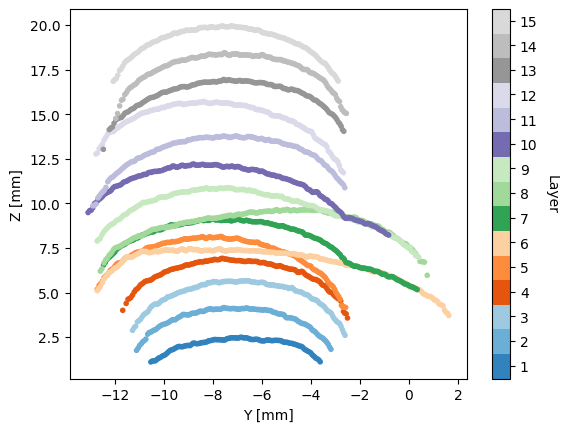

In [ ]:
# # plot entire scan
# plot_all_layers(df_weld_list,0.01,0,0)
# plot_all_layers(df_weld_list,0.01,30,-60)

# plot slice of scan
slice_x = 82 
df_plot_list = []
for df in df_weld_list:
    closest_value = df.X[np.abs(df.X - slice_x).argmin()]
    df = df.drop(df[(df['X'] != closest_value)].index)
    df_plot_list.append(df)

plot_all_layers_2D(df_plot_list,1)


# plot top layer

In [ ]:
# df_top = df_weld_list[-1].copy()
# df_top['labels'] = 'blue'
# fast_scatter(df_top,0.1,30,-60)
# fast_scatter(df_top,0.1,90,0)